In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import normalize
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import KFold


In [2]:
train_df = pd.read_csv('/Users/allenzhang/Desktop/Career/dataset/shanshu/case2_training.csv')

In [3]:
train_df.head()

,ID,Region,Date,Weekday,Apartment,Beds,Review,Pic Quality,Price,Accept
0,1,4,32,5,1,1,4.526975,0.739994,230.552998,0
1,2,2,87,4,1,1,4.548455,0.862642,348.203425,0
2,3,5,277,5,1,2,4.965732,0.515548,430.462327,0
3,4,3,246,2,1,1,4.752735,0.561547,149.305433,1
4,5,1,155,2,1,2,3.890960,0.817142,165.264184,1


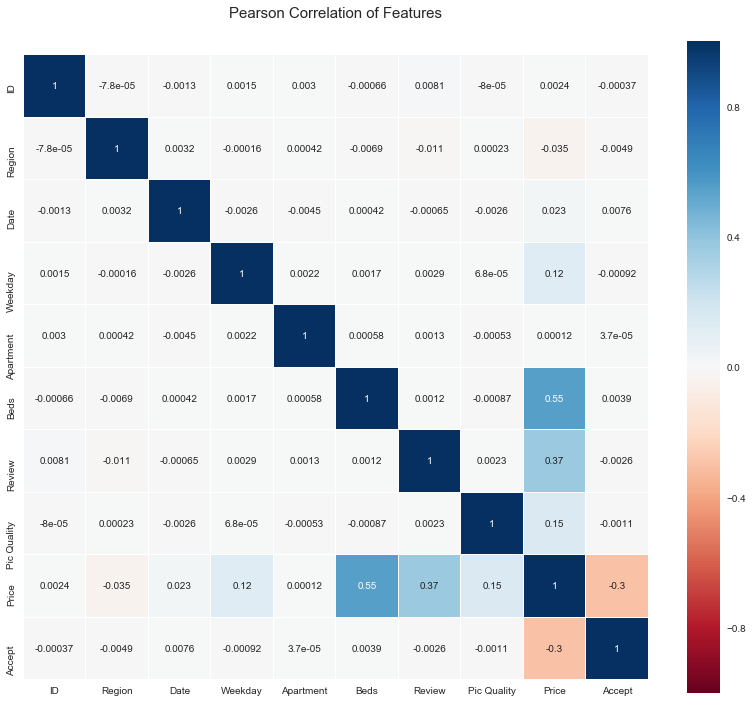

In [4]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train_df.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [ ]:
pd.cut(train_df['Region'], 5)

In [5]:
y = train_df['Accept']

/usr/local/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


[<matplotlib.text.Text at 0x1117d1668>, <matplotlib.text.Text at 0x111756320>]

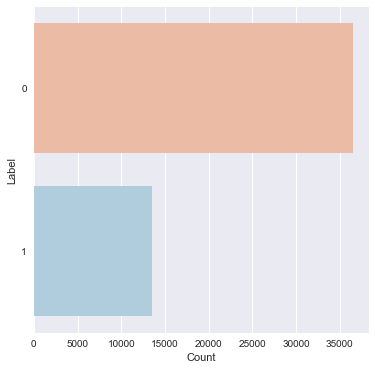

In [6]:
# -------------------------------------------- 
# VISUALISE LABELS AND FREQUENCIES (BAR CHART)
# --------------------------------------------
sns.set_style("whitegrid", {'axes.grid' : True})
plt.figure(figsize=(6,6))
sns.set(style='darkgrid')
ax_label = sns.countplot(y = y, palette="RdBu")
ax_label.set(ylabel = 'Label', xlabel = 'Count')

In [7]:
X = train_df.drop(['Accept'], axis=1)
X = X.drop('ID', axis=1)

normalized_X=(X-X.mean())/X.std()

In [23]:
features_name = X.columns.values

IndexError: too many indices for array

In [15]:
kf = KFold(n_splits=5)

In [ ]:
kf.get_n_splits(X)

### Random Forest

In [24]:
%%time

random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)
random_forest.fit(X_train, y_train)

# Extract feature importances
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features_name, 'importance': feature_importance_values})

# Make predictions on the test data
predictions = random_forest.predict_proba(X_vali)[:, 1]

print(random_forest.score(X_vali, y_vali))

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


0.7315
CPU times: user 9.4 s, sys: 237 ms, total: 9.64 s
Wall time: 2.98 s


In [26]:
feature_importance_values

array([0.07644455, 0.15014911, 0.05600588, 0.01603158, 0.03873139,
       0.18830871, 0.1769944 , 0.29733438])

In [19]:
%%time
acc_list = []
for train_index, vali_index in kf.split(X):
    X_train, X_vali = X.iloc[train_index], X.iloc[vali_index]
    y_train, y_vali = y[train_index], y[vali_index]
    random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)
    random_forest.fit(X_train, y_train)
    acc_list.append(random_forest.score(X_vali, y_vali))

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jo

[0.7286, 0.7271, 0.7271, 0.7288, 0.7315]

## Others

In [ ]:
%%time
clf = LogisticRegression(penalty='l2', max_iter=500, verbose=1)

clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

In [ ]:
%%time
clf = LogisticRegression()

clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

In [ ]:
%%time
clf = SVC(verbose=1)

clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))